In [1]:
# import sys
# print(sys.executable)
# !pip install torch torchvision torchaudio
# for path in sys.path:
#     print(path)

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive
from tqdm import tqdm

running_in_colab = 'google.colab' in str(get_ipython())

if running_in_colab == True:
    drive.mount('/content/gdrive/')
    GOOGLE_DRIVE_PATH_AFTER_GDRIVE = '#####YOUR PATH HERE####### '
    GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_GDRIVE)
    os.chdir(os.path.join('/content',GOOGLE_DRIVE_PATH))
else:
    GOOGLE_DRIVE_PATH = os.path.join('/home/sjchan/3d-perception/point_clouds')
#     GOOGLE_DRIVE_PATH = os.path.join('C:\\Users\\sarah\\OneDrive\\Desktop\\rob599-3D_perception\\point_clouds')
#     os.chdir(GOOGLE_DRIVE_PATH)
    os.chdir(os.path.join('/content',GOOGLE_DRIVE_PATH))

print(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

/home/sjchan/3d-perception/point_clouds
['.ipynb_checkpoints', 'Homework2.ipynb', 'data']


# Instructions:
Download the data from this [link](https://colab.research.google.com/drive/16Q3M_H6L1l_y2xu2MQP6icj6iN75zu18?usp=sharing). Unzip and upload it to your google drive in a folder called ```Homework2```. Make sure all files are stored in a folder called ```data``` inside the folder ```Homework2```. Copy the path after ```gdrive/``` to folder ```Homework2``` and paste it in the space above.

## Q1a. Getting a point cloud from a Depth image

You are given a rgb image, a depth image and a mask. Your task is to generate point cloud data from the given depth image and the corresponding colour from the RGB image. Recall we used projection equations to project 3D points to a 2D plane. Here, given depth, we need to reproject the points back onto a 3D plane. You are also given the camera data (focal length and camera center). Use the data from file ```generate_point_cloud.npz```

```CORRECTION: The pricipal points are not given in the file. Here are the values for the principal point: 0.4224, -0.0300```

![](https://drive.google.com/uc?export=view&id=1Dng54OFGump4H5-m7BLpgoL3ikMLa7aP)


In [22]:
def generate_point_clouds(rgb_image, depth_image, mask, camera_data):
    """
    Generate a 3D point cloud from a given RGB image, depth image, and mask using camera data.

    Args:
        rgb_image (numpy.ndarray): RGB image as a NumPy array.
        depth_image (numpy.ndarray): Depth image as a NumPy array.
        mask (numpy.ndarray): Binary mask indicating valid pixels in the images.
        camera_data (dict): Camera parameters including focal length and camera center.

    Returns:
        point_cloud (numpy.ndarray): 3D point cloud represented as a NumPy array of shape (N, 3),
            where N is the number of valid points.
        rgb (numpy.ndarray): RGB color values corresponding to the 3D points, represented as a
            NumPy array of shape (N, 3), where N is the number of valid points.
    """
    focal_length = camera_data["focal_length"]
    camera_center = camera_data["camera_center"]

    rows, cols = np.shape(depth_image)
    num_pixels = rows * cols
    N = num_pixels - np.sum((mask == 0)*(depth_image==0))
    point_cloud = np.zeros((N, 3))
    rgb = np.zeros((N, 3))

    # projection matrix
    K = np.array([[focal_length[0, 0], 0, 0.4224], [0, focal_length[0, 1], -0.03], [0, 0, 1]])
#     K = np.array([[focal_length[0, 0], 0, camera_center[0, 0]], [0, focal_length[0, 1], camera_center[0, 1]], [0, 0, 1]])
    K_inv = np.linalg.inv(K)
    
    index = 0
    for r in range(rows):
        for c in range(cols):
            if mask[r, c] == 1 and depth_image[r, c] != 0:
                d = depth_image[r, c]/1000
                pixel_coord = np.array([[c], [r], [1]])
                world_coord = d * (K_inv @ pixel_coord)
                point_cloud[index, :] = world_coord.flatten()
                rgb[index, :] = rgb_image[r, c]
                index += 1
    
    return point_cloud, rgb

## Q1b. Generate Visualization

Use the point clouds and rgb data obtained from Q1a and plot them to generate at least 3 different views of the object

```Note: You will need to visualize a lot of point clouds in this assignment. It would help if you generalize this function for future tasks. Feel free to modify input args as needed.```

In [20]:
def visualizing_point_clouds(point_cloud,rgb, elev=70, azim=75):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], color=rgb, alpha=0.5, s=0.2)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim((-1, 2))
    ax.set_ylim((0, 3))
    ax.set_zlim((0.002, 0.008))
    ax.view_init(elev=elev, azim=azim)
    plt.show()

Write a main function to load data and use the functions you defined above to produce the required output:

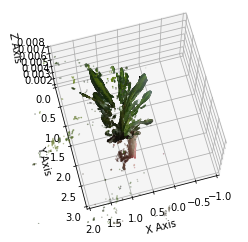

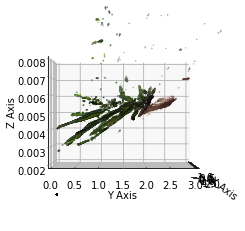

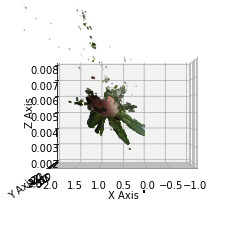

In [21]:
if __name__ == "__main__":
    data = np.load("data/generate_point_cloud.npz")
#     print(data.keys())
    
    rgb_image = data["rgb"]
    depth_image = data["depth"]
    mask = data["mask"]
    camera_data = {"focal_length": data["focal_length"], "camera_center": data["camera_center"]}

    point_cloud, rgb = generate_point_clouds(rgb_image, depth_image, mask, camera_data)
    visualizing_point_clouds(point_cloud, rgb)
    visualizing_point_clouds(point_cloud, rgb, elev=0, azim=0)
    visualizing_point_clouds(point_cloud, rgb, elev=0, azim=90)

# Iterative Closest Point Algorithm

When working with real world point cloud data, one often encounters 2 sets points that are unaligned but represent the same scene or object. These point clouds might be slightly rotated, translated, or even have non-uniform scaling due to various factors such as sensor noise, calibration errors, or deformations in the object itself. In such cases, accurately aligning these point clouds becomes essential to make meaningful comparisons or perform further analysis. The Iterative Closest Point (ICP) algorithm is a powerful tool that addresses this challenge, providing a systematic and efficient way to find the optimal transformation that aligns two point clouds or shapes.

In this section, we are going to develop an in-depth understanding of the ICP algorithm by implementing it and computing a rigid transformation between two point clouds.

Pseudo Code:

![](https://drive.google.com/uc?export=view&id=1XfswHyZWBLb06chYDQRc6Ze6Oiwkxmpd)






## Q2a. Estimate Correspondences between the two point clouds.
You are given two point clouds X and Y, an initial guess of transformation T and rotation R and a threshold for maximum distance between two points.
Return a list of estimated point correspondences. Procedure to follow is given in the pseudocode.

In [32]:
def estimate_correspondences(X, Y, t, R, threshold):
    """
    Estimate Correspondences between two point clouds.

    This function takes two point clouds, X and Y, along with an initial guess of
    translation 't' and rotation 'R', and a threshold value for the maximum distance
    between two points to consider them as correspondences.

    Parameters:
    X (numpy.ndarray): The first point cloud represented as an N x 3 numpy array,
                       where N is the number of points.
    Y (numpy.ndarray): The second point cloud represented as an M x 3 numpy array,
                       where M is the number of points.
    t (numpy.ndarray): The initial guess for translation, a 1 x 3 numpy array.
    R (numpy.ndarray): The initial guess for rotation, a 3 x 3 numpy array.
    threshold (float): The maximum distance between two points to consider them as
                       correspondences.

    Returns:
    correspondences (numpy.ndarray): A numpy array of estimated point correspondences, where each
                            correspondence is [x, y], where 'x' is the index of point
                            from point cloud X, and 'y' is is the index of a point from point cloud Y.
    """
#     correspondences = None
    #########################################
    #############YOUR CODE HERE##############
    #########################################
    N = np.shape(X)[0]
    M = np.shape(Y)[0]
#     print('X', np.shape(X))
#     print('Y', np.shape(Y))
    tra = t
    Rot = R
    
    C = []
#     correspondences = np.zeros((N, 6))
    correspondences = []
    index = 0
    for x in range(N):
        best_dist = threshold
        best_y = -1
        for y in range(M):
            dist = np.linalg.norm(Y[y, :] - (Rot @ X[x, :].T + tra))
            if dist < best_dist:
                best_dist = dist
                best_y = y
        
        if best_y != -1:
            correspondences.append([x, best_y])
            
    correspondences = np.array(correspondences)

    ##########################################
    return correspondences

## Q2b. Estimating Optimal Rigid Transform

Now that we have computed the correspondences, it is time to compute the transform between them. The algorithm to accomplish this task is mentioned below:
![](https://drive.google.com/uc?export=view&id=14JANZvk4sO4CWNqQNhKJx6PT7l7hpKM3)



In [3]:
def compute_rigid_transformation(X,Y,correspondences):
    """
    Estimate the optimal rigid transformation between two point clouds.

    Given two point clouds X and Y, along with a list of estimated point correspondences,
    this function calculates the optimal rotation and translation that best aligns
    point cloud X with point cloud Y.

    Parameters:
    X (numpy.ndarray): The first point cloud represented as an N x 3 numpy array,
                       where N is the number of points.
    Y (numpy.ndarray): The second point cloud represented as an M x 3 numpy array,
                       where M is the number of points.
    correspondences (numpy.ndarray): A numpy array of estimated point correspondences, where each
                            correspondence is [x, y], where 'x' is the index of point
                            from point cloud X, and 'y' is is the index of a point from point cloud Y.

    Returns:
    rotation (numpy.ndarray): The estimated rotation matrix (3x3) that best aligns
                             point cloud X with point cloud Y.
    translation (numpy.ndarray): The estimated translation vector (1x3) that best
                                aligns point cloud X with point cloud Y.
    """
    #########################################
    #############YOUR CODE HERE##############
    #########################################
    N = np.shape(X)[0]
    M = np.shape(Y)[0]
    X_correspondences = X[correspondences[:, 0]]
    Y_correspondences = Y[correspondences[:, 1]]
    x_centroid = np.mean(X_correspondences, axis=0)
    y_centroid = np.mean(Y_correspondences, axis=0)
    x_dist = X_correspondences - x_centroid
    y_dist = Y_correspondences - y_centroid
#     print('x_dist', np.shape(x_dist))
#     print('y_dist', np.shape(y_dist))
    W = 1/N * (x_dist.T @ y_dist)
    U, S, Vt = np.linalg.svd(W)
#     intermediate = np.ones(np.shape(U)[1])
#     intermediate[-1] = np.linalg.det(U @ Vt)
#     rotation = U @ np.diag(intermediate) @ Vt
    rotation = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt
    
    transformation = y_centroid.T - rotation @ x_centroid.T
#     print('rotation', np.shape(rotation))
#     print('transformation', np.shape(transformation))

    ##########################################
    return rotation, transformation

## Q2c. Stitching Everything Together

i. Use the functions you defined in the previous questions and implement the ICP algorithm.

ii. Test the algorithm by using the point clouds in the files ```data/point_cloud_X.txt``` and ```data/point_cloud_Y.txt```. Set initial estimate of ```t``` as 0, ```R``` as identity, ```dmax``` as 0.25 and run the code for 30 iterations

iii. Report the RMSE error computed from the following equation:

![](https://drive.google.com/uc?export=view&id=1cVLvZwm9T1Rj9CKHzQYdZDaokoWqup0O)









In [33]:
def ICP_algorithm(X , Y , t, R, threshold, max_iter):
    #########################################
    #############YOUR CODE HERE##############
    #########################################
    error = 9999
    iteration = 1
    correspondences = []
    while error > threshold:
        if iteration > max_iter:
            break
        else:
            correspondences = []
#             print('Iteration', iteration)
#             print('R', R)
#             print('t', np.shape(t))
            correspondences = estimate_correspondences(X, Y, t, R, threshold)
            R, t = compute_rigid_transformation(X,Y,correspondences)
            error = RMSE_error(X, Y, t, R)
            print('Iteration', iteration, 'RSME:', error)
            iteration = iteration + 1
    
    ##########################################
    return t,R,correspondences


def RMSE_error(X, Y,t,R):
    N = np.shape(X)[0]
#     print('hi from rmse')
#     print('t shape', np.shape(t))
#     print('X shape', np.shape(X))
#     print('Y shape', np.shape(Y))
#     t = t.reshape(N, 3)
#     RMSE = np.linalg.norm((R @ X.T + np.tile(np.reshape(t, (3, 1)), (N, 1))) - Y)# / N
    RMSE = np.linalg.norm((X @ R + t) - Y) / np.sqrt(N)

    return RMSE

#---- Write your 'main' function to load data and use the ICP algorithm -------#
if __name__ == "__main__":
    X = np.loadtxt("data/point_cloud_X.txt")
    Y = np.loadtxt("data/point_cloud_Y.txt")
    
    sample_indices = np.random.choice(X.shape[0], size=1000, replace=False)
    X = X[sample_indices]
    
    t = np.zeros(3)
    R = np.eye(3)

    max_iter = 30
    threshold = 0.5
    t, R, correspondences = ICP_algorithm(X, Y, t, R, threshold, max_iter)
    
    X = np.loadtxt("data/point_cloud_X.txt")
    final_pc = X @ R + t
    
    RMSE = RMSE_error(final_pc, Y, t, R)
    print('Final RMSE: ', RMSE)
    

Iteration 1 RSME: 0.16612006228404194
Final RMSE:  0.49077883392019195


## Q2d. Visualizing the point clouds
Write a function to visualize the two point clouds before and after transformation to witness the might of the ICP algorithm. You are free to use the function you wrote previously for Q1

Before:


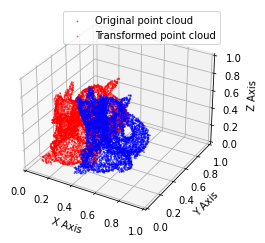

After:


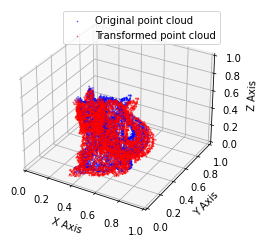

In [30]:
def vis_two_point_clouds(point_cloud1, point_cloud2):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(point_cloud1[:, 0], point_cloud1[:, 1], point_cloud1[:, 2], color='b', alpha=0.5, s=0.6, label='Original point cloud')
    ax.scatter(point_cloud2[:, 0], point_cloud2[:, 1], point_cloud2[:, 2], color='r', alpha=0.5, s=0.6, label='Transformed point cloud')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_zlim((0, 1))
    ax.legend()
    plt.show()

print('Before:')
vis_two_point_clouds(Y, X)

print('After:')
vis_two_point_clouds(Y, final_pc)

# Pointnets

PointNet is a groundbreaking neural network architecture tailored for the classification and segmentation of point cloud data. Introduced in the seminal paper "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Charles R. Qi, Hao Su, Kaichun Mo, and Leonidas J. Guibas, PointNet represents a significant advancement in the field of 3D deep learning.

Processing point clouds poses unique challenges compared to traditional 2D image data. Point clouds are unordered, meaning that the order of the points within the cloud does not inherently convey information. Furthermore, point clouds may have varying numbers of points, making it challenging to apply standard convolutional neural networks (CNNs) designed for regular grids.


In the next few sections, we are going to implement the classification and segmentation network.

## Dataloader

In [2]:
class cocoDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        if train:
            self.data_path = self.path + "/train_data.npy"
            self.label_path = self.path + "/train_labels.npy"
        else:
            self.data_path = self.path + "/test_data.npy"
            self.label_path = self.path + "/test_labels.npy"
        self.data = torch.from_numpy(np.load(self.data_path))
        self.label = torch.from_numpy(np.load(self.label_path)).to(torch.long)

    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def get_data_loader(path, batch_size, train=True):
    """
    Creates training and test data loaders
    """
    dataset = cocoDataset(path, train)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, num_workers=1)


    return dataloader

# Q3. Classification

In this question, you are given point clouds of objects corresponding to 3 different classes: Vase, Chair and Lamp . You are to implement the pointnet neural network and train it to differentiate between different objects.

Note: Use of a GPU is recommended. You can switch to a GPU runtime by going to ```Runtime>Change Runtime Type```


## Q3a. Implementation of Pointnet Architecture.

Refer to the Diagram below to implement the structure of Pointnet for classification.

```Note1: The values in brackets correspond to layers. After every layer there is a 1D Batch normalization layer and a Relu activation layer. Refer to pytorch documentation on how to implement these layers.```

```Note2: Linear layers can also be implemented as 1D Convolutions with Kernel size 1```

```Note3: Remember to use a softmax layer to get the output scores```

![](https://drive.google.com/uc?export=view&id=19k9E94pHVrv8QyNoedNIUi2D-tnDi95t)

Source: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://doi.org/10.48550/arXiv.1612.00593)

In [3]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes = 3, num_points = 1000):
        super(ClassificationModel,self).__init__()
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        self.mlp2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        ##########################################


    def forward(self,points):
        output = None
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        points = points.permute(0, 2, 1)
        points = self.mlp1(points)
        points = self.mlp2(points)
        points = torch.max(points, dim=1)[0]
        output = self.fc_layers(points)
        
        ##########################################
        return output

## Q3b. Training the network

To train the network the following steps need to be followed:


i. Check and convert the dimensions into proper order. Recall, the model needs the data to be in ```B x C x N``` format where B is the batch, C is the channels and N is the number of points

ii. The dataset contains 10000 points per point clouds. To ease the computation, we are only using 1000 points per point cloud. Slice the data so that you are only using 1000 points.

iii. Compute Forward pass

iv. Calculate the Loss. We are using the CrossEntropyLoss for classification.

v. Perform back propogation and optimize

In [4]:
def train(train_dataloader, model, opt, epoch, device, task, num_seg_classes = 6):
    model.train()
    step = epoch*len(train_dataloader)
    epoch_loss = 0

    for i, batch in enumerate(train_dataloader):
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Compute Forward pass
#         B, N, C = point_clouds.size()
        point_clouds = point_clouds.permute(0, 2, 1)
        point_clouds = point_clouds[:, :, :1000]
        predictions = model(point_clouds)
        E = nn.CrossEntropyLoss()
        loss = E(predictions, labels)
        ##########################################

        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Initialize & Calculate Loss and perform back propogation
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        ##########################################
        epoch_loss += loss

    return epoch_loss




## Q3c. Testing the Network

i. Perform the same steps as Q3b to prepare the data for the network.

ii. Get the predictions from your network. Remember to not compute gradients or the loss!

iii. Calculate the accuracy of the model by comparing how many predictions correctly match the labels and dividing the number by total number of datapoints








In [5]:
def test(test_dataloader, model, epoch, device):

    model.eval()

    # Evaluation in Classification Task
    correct_obj = 0
    num_obj = 0
    for batch in test_dataloader:
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################
#         B, N, C = point_clouds.size()
        point_clouds = point_clouds.permute(0, 2, 1)
        point_clouds = point_clouds[:, :, :1000]
        predictions = model(point_clouds)
        predicted_labels = torch.argmax(predictions, dim=1)
        correct_obj += (predicted_labels == labels).sum().item()
        num_obj += labels.size(0)

        #########################################
    # Compute Accuracy of Test Dataset
    accuracy = correct_obj / num_obj

    return accuracy

## Running the Model

In [6]:
NUM_CLASSES = 3
learning_rate = 0.001
path = "data/cls"
batch_size = 32
num_epochs = 150
model_save_path = os.path.join(os. getcwd(), 'model/best_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = ClassificationModel(NUM_CLASSES).to(device)
opt = optim.Adam(model.parameters(), learning_rate, betas=(0.9, 0.999))
train_dataloader = get_data_loader(path,batch_size, True)
test_dataloader = get_data_loader(path,batch_size, False)
print("++++++ SUCCESSFULLY LOADED DATA ++++++")

best_accuracy = -1

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = train(train_dataloader, model, opt, epoch, device, "cls")

    test_accuracy = test(test_dataloader, model, epoch, device)#, "cls")
    print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))

    # if (test_accuracy > best_accuracy):
    #     best_accuracy = test_accuracy
        # torch.save(model.state_dict(), model_save_path)

print("===============TRAINING COMPLETE===============")

++++++ SUCCESSFULLY LOADED DATA ++++++


  1%|          | 1/150 [00:01<04:08,  1.66s/it]

epoch: 0   train loss: 102.2123   test accuracy: 0.8951


  1%|▏         | 2/150 [00:03<03:48,  1.55s/it]

epoch: 1   train loss: 39.3635   test accuracy: 0.9045


  2%|▏         | 3/150 [00:04<03:42,  1.52s/it]

epoch: 2   train loss: 34.3889   test accuracy: 0.9098


  3%|▎         | 4/150 [00:06<03:38,  1.50s/it]

epoch: 3   train loss: 32.9475   test accuracy: 0.9182


  3%|▎         | 5/150 [00:07<03:36,  1.49s/it]

epoch: 4   train loss: 31.8884   test accuracy: 0.9224


  4%|▍         | 6/150 [00:09<03:34,  1.49s/it]

epoch: 5   train loss: 30.6451   test accuracy: 0.9244


  5%|▍         | 7/150 [00:10<03:32,  1.49s/it]

epoch: 6   train loss: 28.9872   test accuracy: 0.9244


  5%|▌         | 8/150 [00:12<03:31,  1.49s/it]

epoch: 7   train loss: 28.8154   test accuracy: 0.9265


  6%|▌         | 9/150 [00:13<03:29,  1.48s/it]

epoch: 8   train loss: 26.6942   test accuracy: 0.9265


  7%|▋         | 10/150 [00:14<03:27,  1.48s/it]

epoch: 9   train loss: 26.4321   test accuracy: 0.9381


  7%|▋         | 11/150 [00:16<03:26,  1.48s/it]

epoch: 10   train loss: 26.4038   test accuracy: 0.9349


  8%|▊         | 12/150 [00:17<03:24,  1.48s/it]

epoch: 11   train loss: 24.7147   test accuracy: 0.9297


  9%|▊         | 13/150 [00:19<03:23,  1.48s/it]

epoch: 12   train loss: 24.6899   test accuracy: 0.9244


  9%|▉         | 14/150 [00:20<03:22,  1.49s/it]

epoch: 13   train loss: 24.4488   test accuracy: 0.9433


 10%|█         | 15/150 [00:22<03:20,  1.48s/it]

epoch: 14   train loss: 23.8662   test accuracy: 0.9360


 11%|█         | 16/150 [00:23<03:18,  1.48s/it]

epoch: 15   train loss: 24.0788   test accuracy: 0.9433


 11%|█▏        | 17/150 [00:25<03:17,  1.49s/it]

epoch: 16   train loss: 23.8943   test accuracy: 0.9255


 12%|█▏        | 18/150 [00:26<03:16,  1.48s/it]

epoch: 17   train loss: 22.4544   test accuracy: 0.9454


 13%|█▎        | 19/150 [00:28<03:14,  1.48s/it]

epoch: 18   train loss: 21.6000   test accuracy: 0.9412


 13%|█▎        | 20/150 [00:29<03:12,  1.48s/it]

epoch: 19   train loss: 22.4502   test accuracy: 0.9433


 14%|█▍        | 21/150 [00:31<03:11,  1.49s/it]

epoch: 20   train loss: 22.3091   test accuracy: 0.9507


 15%|█▍        | 22/150 [00:32<03:10,  1.49s/it]

epoch: 21   train loss: 20.5788   test accuracy: 0.9475


 15%|█▌        | 23/150 [00:34<03:08,  1.48s/it]

epoch: 22   train loss: 21.1506   test accuracy: 0.9528


 16%|█▌        | 24/150 [00:35<03:07,  1.48s/it]

epoch: 23   train loss: 20.0799   test accuracy: 0.9549


 17%|█▋        | 25/150 [00:37<03:05,  1.48s/it]

epoch: 24   train loss: 20.8176   test accuracy: 0.9570


 17%|█▋        | 26/150 [00:38<03:04,  1.49s/it]

epoch: 25   train loss: 20.4972   test accuracy: 0.9507


 18%|█▊        | 27/150 [00:40<03:02,  1.49s/it]

epoch: 26   train loss: 18.8986   test accuracy: 0.9528


 19%|█▊        | 28/150 [00:41<03:01,  1.49s/it]

epoch: 27   train loss: 19.0848   test accuracy: 0.9528


 19%|█▉        | 29/150 [00:43<02:59,  1.49s/it]

epoch: 28   train loss: 18.6510   test accuracy: 0.9538


 20%|██        | 30/150 [00:44<02:58,  1.49s/it]

epoch: 29   train loss: 18.9210   test accuracy: 0.9559


 21%|██        | 31/150 [00:46<02:56,  1.49s/it]

epoch: 30   train loss: 16.9385   test accuracy: 0.9570


 21%|██▏       | 32/150 [00:47<02:55,  1.49s/it]

epoch: 31   train loss: 18.2598   test accuracy: 0.9528


 22%|██▏       | 33/150 [00:49<02:53,  1.48s/it]

epoch: 32   train loss: 17.8693   test accuracy: 0.9570


 23%|██▎       | 34/150 [00:50<02:52,  1.48s/it]

epoch: 33   train loss: 17.7030   test accuracy: 0.9559


 23%|██▎       | 35/150 [00:52<02:50,  1.48s/it]

epoch: 34   train loss: 17.9960   test accuracy: 0.9570


 24%|██▍       | 36/150 [00:53<02:49,  1.49s/it]

epoch: 35   train loss: 15.7776   test accuracy: 0.9538


 25%|██▍       | 37/150 [00:55<02:47,  1.49s/it]

epoch: 36   train loss: 17.1187   test accuracy: 0.9538


 25%|██▌       | 38/150 [00:56<02:46,  1.49s/it]

epoch: 37   train loss: 16.2475   test accuracy: 0.9517


 26%|██▌       | 39/150 [00:58<02:45,  1.49s/it]

epoch: 38   train loss: 16.0408   test accuracy: 0.9643


 27%|██▋       | 40/150 [00:59<02:43,  1.49s/it]

epoch: 39   train loss: 16.2050   test accuracy: 0.9528


 27%|██▋       | 41/150 [01:01<02:42,  1.49s/it]

epoch: 40   train loss: 15.7884   test accuracy: 0.9612


 28%|██▊       | 42/150 [01:02<02:40,  1.49s/it]

epoch: 41   train loss: 15.2756   test accuracy: 0.9370


 29%|██▊       | 43/150 [01:04<02:39,  1.49s/it]

epoch: 42   train loss: 14.9916   test accuracy: 0.9612


 29%|██▉       | 44/150 [01:05<02:37,  1.49s/it]

epoch: 43   train loss: 16.4517   test accuracy: 0.9580


 30%|███       | 45/150 [01:06<02:36,  1.49s/it]

epoch: 44   train loss: 16.1342   test accuracy: 0.9559


 31%|███       | 46/150 [01:08<02:34,  1.49s/it]

epoch: 45   train loss: 16.0426   test accuracy: 0.9601


 31%|███▏      | 47/150 [01:09<02:33,  1.49s/it]

epoch: 46   train loss: 14.5953   test accuracy: 0.9559


 32%|███▏      | 48/150 [01:11<02:31,  1.49s/it]

epoch: 47   train loss: 15.4002   test accuracy: 0.9559


 33%|███▎      | 49/150 [01:12<02:30,  1.49s/it]

epoch: 48   train loss: 14.3925   test accuracy: 0.9538


 33%|███▎      | 50/150 [01:14<02:28,  1.49s/it]

epoch: 49   train loss: 15.3304   test accuracy: 0.9517


 34%|███▍      | 51/150 [01:15<02:27,  1.49s/it]

epoch: 50   train loss: 13.2395   test accuracy: 0.9612


 35%|███▍      | 52/150 [01:17<02:25,  1.49s/it]

epoch: 51   train loss: 14.1868   test accuracy: 0.9580


 35%|███▌      | 53/150 [01:18<02:24,  1.49s/it]

epoch: 52   train loss: 15.5452   test accuracy: 0.9559


 36%|███▌      | 54/150 [01:20<02:22,  1.49s/it]

epoch: 53   train loss: 13.5649   test accuracy: 0.9570


 37%|███▋      | 55/150 [01:21<02:21,  1.49s/it]

epoch: 54   train loss: 13.7792   test accuracy: 0.9601


 37%|███▋      | 56/150 [01:23<02:20,  1.49s/it]

epoch: 55   train loss: 12.9349   test accuracy: 0.9570


 38%|███▊      | 57/150 [01:24<02:18,  1.49s/it]

epoch: 56   train loss: 13.2954   test accuracy: 0.9570


 39%|███▊      | 58/150 [01:26<02:16,  1.49s/it]

epoch: 57   train loss: 14.9121   test accuracy: 0.9496


 39%|███▉      | 59/150 [01:27<02:15,  1.49s/it]

epoch: 58   train loss: 13.4011   test accuracy: 0.9601


 40%|████      | 60/150 [01:29<02:14,  1.49s/it]

epoch: 59   train loss: 15.3879   test accuracy: 0.9612


 41%|████      | 61/150 [01:30<02:12,  1.49s/it]

epoch: 60   train loss: 12.5974   test accuracy: 0.9423


 41%|████▏     | 62/150 [01:32<02:10,  1.49s/it]

epoch: 61   train loss: 12.9896   test accuracy: 0.9612


 42%|████▏     | 63/150 [01:33<02:09,  1.49s/it]

epoch: 62   train loss: 14.0911   test accuracy: 0.9633


 43%|████▎     | 64/150 [01:35<02:08,  1.49s/it]

epoch: 63   train loss: 12.6402   test accuracy: 0.9549


 43%|████▎     | 65/150 [01:36<02:06,  1.49s/it]

epoch: 64   train loss: 11.9587   test accuracy: 0.9612


 44%|████▍     | 66/150 [01:38<02:05,  1.49s/it]

epoch: 65   train loss: 11.4641   test accuracy: 0.9622


 45%|████▍     | 67/150 [01:39<02:03,  1.49s/it]

epoch: 66   train loss: 11.0867   test accuracy: 0.9528


 45%|████▌     | 68/150 [01:41<02:02,  1.49s/it]

epoch: 67   train loss: 14.7610   test accuracy: 0.9601


 46%|████▌     | 69/150 [01:42<02:00,  1.49s/it]

epoch: 68   train loss: 11.3588   test accuracy: 0.9685


 47%|████▋     | 70/150 [01:44<01:59,  1.49s/it]

epoch: 69   train loss: 12.8486   test accuracy: 0.9633


 47%|████▋     | 71/150 [01:45<01:57,  1.49s/it]

epoch: 70   train loss: 10.7881   test accuracy: 0.9612


 48%|████▊     | 72/150 [01:47<01:55,  1.49s/it]

epoch: 71   train loss: 11.9441   test accuracy: 0.9580


 49%|████▊     | 73/150 [01:48<01:54,  1.49s/it]

epoch: 72   train loss: 10.9585   test accuracy: 0.9654


 49%|████▉     | 74/150 [01:50<01:53,  1.49s/it]

epoch: 73   train loss: 12.0429   test accuracy: 0.9612


 50%|█████     | 75/150 [01:51<01:51,  1.49s/it]

epoch: 74   train loss: 10.5516   test accuracy: 0.9643


 51%|█████     | 76/150 [01:53<01:50,  1.49s/it]

epoch: 75   train loss: 9.4878   test accuracy: 0.9580


 51%|█████▏    | 77/150 [01:54<01:48,  1.49s/it]

epoch: 76   train loss: 9.2658   test accuracy: 0.9559


 52%|█████▏    | 78/150 [01:56<01:47,  1.49s/it]

epoch: 77   train loss: 15.9640   test accuracy: 0.9549


 53%|█████▎    | 79/150 [01:57<01:45,  1.49s/it]

epoch: 78   train loss: 12.3225   test accuracy: 0.9580


 53%|█████▎    | 80/150 [01:59<01:44,  1.49s/it]

epoch: 79   train loss: 10.7728   test accuracy: 0.9675


 54%|█████▍    | 81/150 [02:00<01:42,  1.49s/it]

epoch: 80   train loss: 10.5844   test accuracy: 0.9580


 55%|█████▍    | 82/150 [02:02<01:41,  1.49s/it]

epoch: 81   train loss: 10.2738   test accuracy: 0.9664


 55%|█████▌    | 83/150 [02:03<01:39,  1.49s/it]

epoch: 82   train loss: 9.8157   test accuracy: 0.9612


 56%|█████▌    | 84/150 [02:05<01:38,  1.49s/it]

epoch: 83   train loss: 10.8666   test accuracy: 0.9664


 57%|█████▋    | 85/150 [02:06<01:36,  1.49s/it]

epoch: 84   train loss: 9.6725   test accuracy: 0.9591


 57%|█████▋    | 86/150 [02:07<01:35,  1.49s/it]

epoch: 85   train loss: 9.7062   test accuracy: 0.9486


 58%|█████▊    | 87/150 [02:09<01:33,  1.49s/it]

epoch: 86   train loss: 11.7551   test accuracy: 0.9580


 59%|█████▊    | 88/150 [02:10<01:32,  1.49s/it]

epoch: 87   train loss: 10.4281   test accuracy: 0.9654


 59%|█████▉    | 89/150 [02:12<01:30,  1.49s/it]

epoch: 88   train loss: 8.7333   test accuracy: 0.9622


 60%|██████    | 90/150 [02:13<01:29,  1.49s/it]

epoch: 89   train loss: 9.0971   test accuracy: 0.9549


 61%|██████    | 91/150 [02:15<01:27,  1.49s/it]

epoch: 90   train loss: 10.2837   test accuracy: 0.9633


 61%|██████▏   | 92/150 [02:16<01:26,  1.49s/it]

epoch: 91   train loss: 9.3849   test accuracy: 0.9570


 62%|██████▏   | 93/150 [02:18<01:24,  1.49s/it]

epoch: 92   train loss: 10.0605   test accuracy: 0.9549


 63%|██████▎   | 94/150 [02:19<01:23,  1.49s/it]

epoch: 93   train loss: 8.6829   test accuracy: 0.9664


 63%|██████▎   | 95/150 [02:21<01:21,  1.49s/it]

epoch: 94   train loss: 9.4588   test accuracy: 0.9580


 64%|██████▍   | 96/150 [02:22<01:20,  1.49s/it]

epoch: 95   train loss: 9.0697   test accuracy: 0.9675


 65%|██████▍   | 97/150 [02:24<01:18,  1.49s/it]

epoch: 96   train loss: 7.6342   test accuracy: 0.9664


 65%|██████▌   | 98/150 [02:25<01:17,  1.49s/it]

epoch: 97   train loss: 8.1197   test accuracy: 0.9654


 66%|██████▌   | 99/150 [02:27<01:15,  1.49s/it]

epoch: 98   train loss: 11.5205   test accuracy: 0.9486


 67%|██████▋   | 100/150 [02:28<01:14,  1.49s/it]

epoch: 99   train loss: 12.5697   test accuracy: 0.9633


 67%|██████▋   | 101/150 [02:30<01:12,  1.49s/it]

epoch: 100   train loss: 9.2630   test accuracy: 0.9654


 68%|██████▊   | 102/150 [02:31<01:11,  1.49s/it]

epoch: 101   train loss: 7.7388   test accuracy: 0.9622


 69%|██████▊   | 103/150 [02:33<01:09,  1.49s/it]

epoch: 102   train loss: 10.7561   test accuracy: 0.9591


 69%|██████▉   | 104/150 [02:34<01:08,  1.49s/it]

epoch: 103   train loss: 8.1134   test accuracy: 0.9580


 70%|███████   | 105/150 [02:36<01:06,  1.49s/it]

epoch: 104   train loss: 8.5317   test accuracy: 0.9685


 71%|███████   | 106/150 [02:37<01:05,  1.49s/it]

epoch: 105   train loss: 7.5301   test accuracy: 0.9601


 71%|███████▏  | 107/150 [02:39<01:03,  1.49s/it]

epoch: 106   train loss: 8.7346   test accuracy: 0.9591


 72%|███████▏  | 108/150 [02:40<01:02,  1.49s/it]

epoch: 107   train loss: 8.2126   test accuracy: 0.9601


 73%|███████▎  | 109/150 [02:42<01:00,  1.49s/it]

epoch: 108   train loss: 9.8281   test accuracy: 0.9633


 73%|███████▎  | 110/150 [02:43<00:59,  1.49s/it]

epoch: 109   train loss: 10.5651   test accuracy: 0.9601


 74%|███████▍  | 111/150 [02:45<00:57,  1.49s/it]

epoch: 110   train loss: 6.7968   test accuracy: 0.9664


 75%|███████▍  | 112/150 [02:46<00:56,  1.49s/it]

epoch: 111   train loss: 8.6794   test accuracy: 0.9675


 75%|███████▌  | 113/150 [02:48<00:55,  1.49s/it]

epoch: 112   train loss: 8.1794   test accuracy: 0.9496


 76%|███████▌  | 114/150 [02:49<00:53,  1.49s/it]

epoch: 113   train loss: 12.6659   test accuracy: 0.9622


 77%|███████▋  | 115/150 [02:51<00:52,  1.49s/it]

epoch: 114   train loss: 7.6340   test accuracy: 0.9633


 77%|███████▋  | 116/150 [02:52<00:50,  1.49s/it]

epoch: 115   train loss: 6.8894   test accuracy: 0.9664


 78%|███████▊  | 117/150 [02:54<00:49,  1.49s/it]

epoch: 116   train loss: 13.1273   test accuracy: 0.9496


 79%|███████▊  | 118/150 [02:55<00:47,  1.49s/it]

epoch: 117   train loss: 9.8534   test accuracy: 0.9654


 79%|███████▉  | 119/150 [02:57<00:46,  1.49s/it]

epoch: 118   train loss: 8.0649   test accuracy: 0.9654


 80%|████████  | 120/150 [02:58<00:44,  1.49s/it]

epoch: 119   train loss: 7.1089   test accuracy: 0.9664


 81%|████████  | 121/150 [03:00<00:43,  1.49s/it]

epoch: 120   train loss: 8.3969   test accuracy: 0.9622


 81%|████████▏ | 122/150 [03:01<00:41,  1.49s/it]

epoch: 121   train loss: 7.3331   test accuracy: 0.9643


 82%|████████▏ | 123/150 [03:03<00:40,  1.49s/it]

epoch: 122   train loss: 8.8728   test accuracy: 0.9654


 83%|████████▎ | 124/150 [03:04<00:38,  1.49s/it]

epoch: 123   train loss: 9.4822   test accuracy: 0.9612


 83%|████████▎ | 125/150 [03:06<00:37,  1.49s/it]

epoch: 124   train loss: 8.6248   test accuracy: 0.9643


 84%|████████▍ | 126/150 [03:07<00:35,  1.49s/it]

epoch: 125   train loss: 8.6444   test accuracy: 0.9601


 85%|████████▍ | 127/150 [03:09<00:34,  1.49s/it]

epoch: 126   train loss: 7.1091   test accuracy: 0.9643


 85%|████████▌ | 128/150 [03:10<00:32,  1.49s/it]

epoch: 127   train loss: 6.9038   test accuracy: 0.9643


 86%|████████▌ | 129/150 [03:11<00:31,  1.49s/it]

epoch: 128   train loss: 8.7401   test accuracy: 0.9559


 87%|████████▋ | 130/150 [03:13<00:29,  1.49s/it]

epoch: 129   train loss: 7.9708   test accuracy: 0.9591


 87%|████████▋ | 131/150 [03:14<00:28,  1.49s/it]

epoch: 130   train loss: 7.2954   test accuracy: 0.9643


 88%|████████▊ | 132/150 [03:16<00:26,  1.49s/it]

epoch: 131   train loss: 6.6896   test accuracy: 0.9643


 89%|████████▊ | 133/150 [03:17<00:25,  1.49s/it]

epoch: 132   train loss: 6.2293   test accuracy: 0.9622


 89%|████████▉ | 134/150 [03:19<00:23,  1.49s/it]

epoch: 133   train loss: 10.8922   test accuracy: 0.9570


 90%|█████████ | 135/150 [03:20<00:22,  1.49s/it]

epoch: 134   train loss: 6.3476   test accuracy: 0.9580


 91%|█████████ | 136/150 [03:22<00:20,  1.49s/it]

epoch: 135   train loss: 7.6447   test accuracy: 0.9612


 91%|█████████▏| 137/150 [03:23<00:19,  1.49s/it]

epoch: 136   train loss: 7.6681   test accuracy: 0.9580


 92%|█████████▏| 138/150 [03:25<00:17,  1.49s/it]

epoch: 137   train loss: 7.8908   test accuracy: 0.9580


 93%|█████████▎| 139/150 [03:26<00:16,  1.49s/it]

epoch: 138   train loss: 6.2130   test accuracy: 0.9633


 93%|█████████▎| 140/150 [03:28<00:14,  1.49s/it]

epoch: 139   train loss: 6.1952   test accuracy: 0.9643


 94%|█████████▍| 141/150 [03:29<00:13,  1.49s/it]

epoch: 140   train loss: 7.1187   test accuracy: 0.9685


 95%|█████████▍| 142/150 [03:31<00:11,  1.49s/it]

epoch: 141   train loss: 6.7421   test accuracy: 0.9633


 95%|█████████▌| 143/150 [03:32<00:10,  1.49s/it]

epoch: 142   train loss: 8.1797   test accuracy: 0.9570


 96%|█████████▌| 144/150 [03:34<00:08,  1.49s/it]

epoch: 143   train loss: 8.1804   test accuracy: 0.9685


 97%|█████████▋| 145/150 [03:35<00:07,  1.49s/it]

epoch: 144   train loss: 6.3389   test accuracy: 0.9664


 97%|█████████▋| 146/150 [03:37<00:05,  1.49s/it]

epoch: 145   train loss: 7.8321   test accuracy: 0.9664


 98%|█████████▊| 147/150 [03:38<00:04,  1.49s/it]

epoch: 146   train loss: 5.8454   test accuracy: 0.9654


 99%|█████████▊| 148/150 [03:40<00:02,  1.49s/it]

epoch: 147   train loss: 8.3303   test accuracy: 0.9685


 99%|█████████▉| 149/150 [03:41<00:01,  1.49s/it]

epoch: 148   train loss: 7.2281   test accuracy: 0.9664


100%|██████████| 150/150 [03:43<00:00,  1.49s/it]

epoch: 149   train loss: 4.9559   test accuracy: 0.9654
===============TRAINING COMPLETE===============


## Q3d. Inference

i. Visualize few point clouds that have been classified correctly

ii. Visualize few point clouds that have been classfied incorrectly

You can re-use functions defined previously

In [20]:
def visualizing_point_clouds_pointnet(point_cloud,rgb):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], color=rgb, alpha=0.5, s=0.2)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.show()

correct = []
incorrect = []

for point_clouds, labels in test_dataloader:
    point_clouds = point_clouds.to(device)
    labels = labels.to(device)
    point_clouds_input = point_clouds.permute(0, 2, 1)[:, :, :1000]
    preds = model(point_clouds_input)
    predicted_labels = torch.argmax(preds, dim=1)

    for pc, label, pred in zip(point_clouds.cpu(), labels.cpu(), predicted_labels.cpu()):
        if label == pred:
            correct.append((pc, label.item(), pred.item()))
        else:
            incorrect.append((pc, label.item(), pred.item()))
            
print('Correctly classified samples')
for i in range(0, len(correct), int(len(correct)/5)):
    pc, label, pred = correct[i]
    print(f"Label: {label}, Prediction: {pred}")
    visualizing_point_clouds_pointnet(pc, rgb='g')
    
print('Incorrectly classified samples')
for i in range(0, len(incorrect), int(len(incorrect)/5)):
    pc, label, pred = incorrect[i]
    print(f"Label: {label}, Prediction: {pred}")
    visualizing_point_clouds_pointnet(pc, rgb='r')

RuntimeError: Given groups=1, weight of size [64, 3, 1], expected input[32, 1000, 3] to have 3 channels, but got 1000 channels instead

# Q4. Segmentation

In this question, you are given a point cloud of different types of chairs with labels or classes for different parts of the chair: back rest, arm rest, seat etc. Your task is to create a PointNet segmentation network and train it to perform part segmentation.

Note: Use of a GPU is recommended. You can switch to a GPU runtime by going to ```Runtime>Change Runtime Type```

## Q4a. Implementation of the Pointnet architecture for segmentation

The architecture of pointnet for segmentation is given below:

![](https://drive.google.com/uc?export=view&id=1gATiXB-CD6LmetMjylBbg230CoowyVud)
Source: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://doi.org/10.48550/arXiv.1612.00593)

There are a total of 6 classes that the points can be segmented into.

For segmentation, we store the local features extracted after the first set of MLP layers and concatenate each point in the local feature tensor with the global feature vector, making the input to the segmentation network ```n x (64+ 1024) =  nx1088```

```Note1: The values in brackets correspond to layers. After every layer there is a 1D Batch normalization layer and a Relu activation layer. Refer to pytorch documentation on how to implement these layers.```

```Note2: Your implementation should not contain the input transform and the feature transform```

```Note3: MLP can also be implemented as 1D Convolutions with Kernel size 1```






In [3]:
class SegmentationNetwork(nn.Module):
    def __init__(self, num_points = 2000, num_seg_classes = 6):
        super(SegmentationNetwork,self).__init__()
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.seg_mlp = nn.Sequential(
            nn.Conv1d(1088, 512, 1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, num_seg_classes, kernel_size=1)  # No activation
        )

        ##########################################


    def forward(self,points):
        """
        Implement the forward pass
        Parameters:
        points (torch.Tensor): Tensor of shape (BxCxN) containing point cloud data
        where B is the batch size, C is number of channels, N is number of points in the point cloud

        Returns:
        output (torch.Tensor): Tensor of shape (B x num_seg_classes x N)
        """
        output = None
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        points = points.transpose(1, 2)
        B, _, N = points.size()
        local_feat = self.mlp1(points)
        global_feat = self.mlp2(local_feat)
        global_feat = torch.max(global_feat, 2, keepdim=True)[0]
        global_feat_expanded = global_feat.repeat(1, 1, N)
        concat_feat = torch.cat([local_feat, global_feat_expanded], dim=1)
        output = self.seg_mlp(concat_feat)
        ##########################################
        return output

## Q4b. Implementing the loss function

In this case, we need a special loss function because our data is not uniformly distributed. To illustrate it further run the following block:

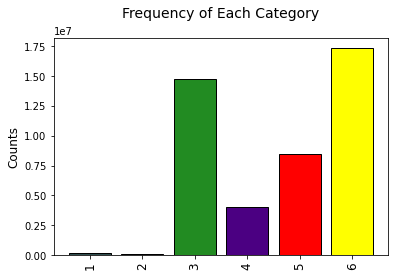

In [11]:
## RUN this block for the plot
CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
COLOR_MAP = {
    0  : (47, 79, 79),
    1  : (139, 69, 19),
    2  : (34, 139, 34),
    3  : (75, 0, 130),
    4  : (255, 0, 0),
    5  : (255, 255, 0)}
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])
NUM_CLASSES = len(CATEGORIES)
total_train_targets = []
train_dataloader = get_data_loader("data/seg",32, True)
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins,
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Frequency of Each Category', size=14, pad=20);

We observe a significant imbalance in the dataset. Penalizing the network equally for misclassifying categories of varying frequencies wouldn't be logical. If we penalize high-frequency categories the same as low-frequency ones, the model might excel at capturing common patterns but struggle with rare features.

For this reason, we define a few weights for the loss function that correspond to the different classes. These are learnable parameters and we are initializing them manually as per the visualization. You are free to experiment with them as you please.

In [4]:
alpha = np.ones(6)
alpha[5] *= 0.25
alpha[2] *= 0.35
alpha[4] *= 0.45
alpha[3] *= 0.5

Initialize the cross entropy loss with the weights and perform the forward pass. Refer to the pytorch documentation on Cross Entropy loss for  more information.

In [5]:
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        self.loss = nn.CrossEntropyLoss()
        ##########################################

    def forward(self, predictions, targets):
        loss = None
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        B, C, N = predictions.size()
        predictions = predictions.permute(0, 2, 1).contiguous().view(-1, C)
        targets = targets.view(-1)
        loss = self.loss(predictions, targets)
        ##########################################
        return loss

## Q4c. Training the Network

To train the network the following steps need to be followed:

i. Check and convert the dimensions into proper order. Recall, the model needs the data to be in ```B x C x N``` format where B is the batch, C is the channels and N is the number of points

ii. The dataset contains 10000 points per point clouds. To reduce computation, we are only using 2000 points per point cloud. Slice the data so that you are only using 2000 points.

iii. Compute Forward pass

iv. Calculate the Loss. Here the ```PointNetSegLoss``` is passed as the argument ```criterion``` in the function

v. Perform back propogation and optimize

In [6]:
def train_segmentation_model(train_dataloader, model, opt, epoch, device, criterion, num_seg_classes = 6):
    model.train()

    step = epoch*len(train_dataloader)
    epoch_loss = 0

    for i, batch in enumerate(train_dataloader):
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Compute Forward pass
        predictions = model(point_clouds)

        ##########################################




        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Initialize & Calculate Loss and perform back propogation
        loss = criterion(predictions, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

        ##########################################
        epoch_loss += loss

    return epoch_loss

## Q4d. Testing the Network

i. Perform the same steps as Q4c to prepare the data for the network.

ii. Get the predictions from your network. Remember to not compute gradients or the loss!

iii. Get the prediction with highest probability from the output by using ```torch.softmax```

iv. Calculate the accuracy of the model by comparing how many predictions correctly match the labels and dividing the number by total number of datapoints

In [21]:
def test_segmentation_model(test_dataloader, model, epoch, device):

    model.eval()
    correct_point = 0
    num_point = 0
    for batch in test_dataloader:
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Compute Forward pass and evaluate the model
        predictions = model(point_clouds.permute(0, 2, 1))
        pred_classes = predictions.argmax(dim=1)
        correct_point += (pred_classes == labels).sum().item()
        num_point += labels.numel()

        ##########################################
    # Compute Accuracy of Test Dataset
    accuracy = correct_point / num_point

    return accuracy

## Running the Model

In [9]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
NUM_CLASSES = 6
NUM_TRAIN_POINTS = 2000
learning_rate = 0.001
path = "data/seg"
batch_size = 32
num_epochs = 200
model = SegmentationNetwork(NUM_TRAIN_POINTS, NUM_CLASSES)
model_save_path = os.path.join(os. getcwd(), 'model/best_seg_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
opt = optim.Adam(model.parameters(), learning_rate)
train_dataloader = get_data_loader(path,batch_size, True)
test_dataloader = get_data_loader(path,batch_size, False)


alpha = np.ones(6)
alpha[-1] *= 0.25
alpha[2] *= 0.35
alpha[4] *= 0.45
alpha[3] *= 0.5

criterion = PointNetSegLoss(alpha=alpha).to(device)

model = model.to(device)
print("++++++ SUCCESSFULLY LOADED DATA ++++++")

best_accuracy = -1

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = train_segmentation_model(train_dataloader, model, opt, epoch, device, criterion)

    test_accuracy = test_segmentation_model(test_dataloader, model, epoch, device)
    print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)

print("===============TRAINING COMPLETE===============")

++++++ SUCCESSFULLY LOADED DATA ++++++


  0%|          | 1/200 [00:42<2:22:07, 42.85s/it]

epoch: 0   train loss: 68.9321   test accuracy: 0.7945


  1%|          | 2/200 [01:26<2:22:01, 43.04s/it]

epoch: 1   train loss: 49.4370   test accuracy: 0.7697


  2%|▏         | 3/200 [02:08<2:21:12, 43.01s/it]

epoch: 2   train loss: 46.6355   test accuracy: 0.8469


  2%|▏         | 4/200 [02:51<2:20:19, 42.96s/it]

epoch: 3   train loss: 44.2313   test accuracy: 0.8512


  2%|▎         | 5/200 [03:34<2:19:32, 42.93s/it]

epoch: 4   train loss: 43.0795   test accuracy: 0.5151


  3%|▎         | 6/200 [04:17<2:18:40, 42.89s/it]

epoch: 5   train loss: 41.5111   test accuracy: 0.8396


  4%|▎         | 7/200 [05:00<2:18:03, 42.92s/it]

epoch: 6   train loss: 40.8780   test accuracy: 0.7975


  4%|▍         | 8/200 [05:43<2:17:25, 42.95s/it]

epoch: 7   train loss: 39.7117   test accuracy: 0.8635


  4%|▍         | 9/200 [06:26<2:16:50, 42.99s/it]

epoch: 8   train loss: 38.6256   test accuracy: 0.8527


  5%|▌         | 10/200 [07:09<2:16:11, 43.01s/it]

epoch: 9   train loss: 38.3505   test accuracy: 0.7992


  6%|▌         | 11/200 [07:52<2:15:27, 43.00s/it]

epoch: 10   train loss: 37.1080   test accuracy: 0.5597


  6%|▌         | 12/200 [08:35<2:14:50, 43.04s/it]

epoch: 11   train loss: 36.9373   test accuracy: 0.8228


  6%|▋         | 13/200 [09:18<2:14:02, 43.01s/it]

epoch: 12   train loss: 36.1634   test accuracy: 0.8222


  7%|▋         | 14/200 [10:01<2:13:30, 43.07s/it]

epoch: 13   train loss: 35.2509   test accuracy: 0.7667


  8%|▊         | 15/200 [10:45<2:12:51, 43.09s/it]

epoch: 14   train loss: 34.9410   test accuracy: 0.8400


  8%|▊         | 16/200 [11:28<2:11:59, 43.04s/it]

epoch: 15   train loss: 34.2336   test accuracy: 0.8079


  8%|▊         | 17/200 [12:11<2:11:17, 43.04s/it]

epoch: 16   train loss: 33.7418   test accuracy: 0.8186


  9%|▉         | 18/200 [12:54<2:10:30, 43.02s/it]

epoch: 17   train loss: 33.3045   test accuracy: 0.8528


 10%|▉         | 19/200 [13:37<2:09:49, 43.04s/it]

epoch: 18   train loss: 32.9001   test accuracy: 0.8472


 10%|█         | 20/200 [14:20<2:09:10, 43.06s/it]

epoch: 19   train loss: 31.8173   test accuracy: 0.8043


 10%|█         | 21/200 [15:03<2:08:24, 43.04s/it]

epoch: 20   train loss: 31.4510   test accuracy: 0.8616


 11%|█         | 22/200 [15:46<2:07:45, 43.06s/it]

epoch: 21   train loss: 30.8340   test accuracy: 0.8462


 12%|█▏        | 23/200 [16:29<2:07:17, 43.15s/it]

epoch: 22   train loss: 30.8460   test accuracy: 0.7592


 12%|█▏        | 24/200 [17:12<2:06:36, 43.16s/it]

epoch: 23   train loss: 30.0728   test accuracy: 0.7509


 12%|█▎        | 25/200 [17:56<2:05:53, 43.16s/it]

epoch: 24   train loss: 29.8952   test accuracy: 0.7300


 13%|█▎        | 26/200 [18:39<2:05:12, 43.17s/it]

epoch: 25   train loss: 29.9638   test accuracy: 0.7938


 14%|█▎        | 27/200 [19:22<2:04:25, 43.15s/it]

epoch: 26   train loss: 29.3554   test accuracy: 0.8652


 14%|█▍        | 28/200 [20:05<2:03:49, 43.20s/it]

epoch: 27   train loss: 28.7380   test accuracy: 0.8450


 14%|█▍        | 29/200 [20:48<2:03:02, 43.17s/it]

epoch: 28   train loss: 28.2611   test accuracy: 0.8486


 15%|█▌        | 30/200 [21:31<2:02:07, 43.10s/it]

epoch: 29   train loss: 27.8634   test accuracy: 0.8125


 16%|█▌        | 31/200 [22:14<2:01:24, 43.10s/it]

epoch: 30   train loss: 27.7134   test accuracy: 0.8179


 16%|█▌        | 32/200 [22:57<2:00:45, 43.13s/it]

epoch: 31   train loss: 27.4970   test accuracy: 0.8437


 16%|█▋        | 33/200 [23:41<2:00:05, 43.15s/it]

epoch: 32   train loss: 27.8866   test accuracy: 0.8618


 17%|█▋        | 34/200 [24:24<1:59:22, 43.15s/it]

epoch: 33   train loss: 26.9483   test accuracy: 0.7890


 18%|█▊        | 35/200 [25:07<1:58:35, 43.12s/it]

epoch: 34   train loss: 26.4514   test accuracy: 0.8447


 18%|█▊        | 36/200 [25:50<1:57:51, 43.12s/it]

epoch: 35   train loss: 26.3679   test accuracy: 0.8205


 18%|█▊        | 37/200 [26:33<1:57:15, 43.16s/it]

epoch: 36   train loss: 25.7450   test accuracy: 0.8084


 19%|█▉        | 38/200 [27:17<1:56:37, 43.20s/it]

epoch: 37   train loss: 26.5921   test accuracy: 0.8825


 20%|█▉        | 39/200 [28:00<1:55:52, 43.19s/it]

epoch: 38   train loss: 25.3609   test accuracy: 0.8624


 20%|██        | 40/200 [28:43<1:55:11, 43.20s/it]

epoch: 39   train loss: 25.6623   test accuracy: 0.7637


 20%|██        | 41/200 [29:26<1:54:24, 43.17s/it]

epoch: 40   train loss: 25.3868   test accuracy: 0.7972


 21%|██        | 42/200 [30:09<1:53:43, 43.19s/it]

epoch: 41   train loss: 24.5998   test accuracy: 0.8582


 22%|██▏       | 43/200 [30:52<1:52:57, 43.17s/it]

epoch: 42   train loss: 24.6340   test accuracy: 0.8639


 22%|██▏       | 44/200 [31:36<1:52:14, 43.17s/it]

epoch: 43   train loss: 24.1883   test accuracy: 0.8398


 22%|██▎       | 45/200 [32:19<1:51:31, 43.17s/it]

epoch: 44   train loss: 24.0452   test accuracy: 0.8526


 23%|██▎       | 46/200 [33:02<1:50:46, 43.16s/it]

epoch: 45   train loss: 23.4551   test accuracy: 0.8545


 24%|██▎       | 47/200 [33:45<1:50:01, 43.15s/it]

epoch: 46   train loss: 23.5302   test accuracy: 0.7116


 24%|██▍       | 48/200 [34:28<1:49:14, 43.12s/it]

epoch: 47   train loss: 25.4674   test accuracy: 0.8663


 24%|██▍       | 49/200 [35:11<1:48:44, 43.21s/it]

epoch: 48   train loss: 23.3965   test accuracy: 0.8624


 25%|██▌       | 50/200 [35:55<1:48:03, 43.22s/it]

epoch: 49   train loss: 22.8091   test accuracy: 0.8497


 26%|██▌       | 51/200 [36:38<1:47:23, 43.24s/it]

epoch: 50   train loss: 22.7399   test accuracy: 0.8600


 26%|██▌       | 52/200 [37:21<1:46:36, 43.22s/it]

epoch: 51   train loss: 22.5833   test accuracy: 0.8362


 26%|██▋       | 53/200 [38:04<1:45:51, 43.21s/it]

epoch: 52   train loss: 22.3545   test accuracy: 0.8590


 27%|██▋       | 54/200 [38:47<1:45:04, 43.18s/it]

epoch: 53   train loss: 22.4151   test accuracy: 0.8576


 28%|██▊       | 55/200 [39:31<1:44:23, 43.20s/it]

epoch: 54   train loss: 21.9258   test accuracy: 0.8550


 28%|██▊       | 56/200 [40:14<1:43:46, 43.24s/it]

epoch: 55   train loss: 22.5149   test accuracy: 0.8546


 28%|██▊       | 57/200 [40:57<1:43:02, 43.23s/it]

epoch: 56   train loss: 22.4904   test accuracy: 0.8665


 29%|██▉       | 58/200 [41:41<1:42:24, 43.27s/it]

epoch: 57   train loss: 22.9792   test accuracy: 0.7979


 30%|██▉       | 59/200 [42:24<1:41:33, 43.22s/it]

epoch: 58   train loss: 22.5938   test accuracy: 0.7706


 30%|███       | 60/200 [43:07<1:40:48, 43.20s/it]

epoch: 59   train loss: 21.1368   test accuracy: 0.8694


 30%|███       | 61/200 [43:50<1:40:06, 43.21s/it]

epoch: 60   train loss: 20.8242   test accuracy: 0.8656


 31%|███       | 62/200 [44:33<1:39:26, 43.24s/it]

epoch: 61   train loss: 20.9092   test accuracy: 0.8872


 32%|███▏      | 63/200 [45:17<1:38:44, 43.25s/it]

epoch: 62   train loss: 20.7249   test accuracy: 0.8504


 32%|███▏      | 64/200 [46:00<1:38:07, 43.29s/it]

epoch: 63   train loss: 20.6465   test accuracy: 0.8545


 32%|███▎      | 65/200 [46:43<1:37:23, 43.29s/it]

epoch: 64   train loss: 20.4551   test accuracy: 0.8549


 33%|███▎      | 66/200 [47:27<1:36:39, 43.28s/it]

epoch: 65   train loss: 20.7801   test accuracy: 0.8768


 34%|███▎      | 67/200 [48:10<1:35:56, 43.29s/it]

epoch: 66   train loss: 20.3488   test accuracy: 0.8568


 34%|███▍      | 68/200 [48:53<1:35:13, 43.28s/it]

epoch: 67   train loss: 20.0823   test accuracy: 0.7599


 34%|███▍      | 69/200 [49:36<1:34:24, 43.24s/it]

epoch: 68   train loss: 19.9480   test accuracy: 0.8804


 35%|███▌      | 70/200 [50:19<1:33:37, 43.21s/it]

epoch: 69   train loss: 19.6594   test accuracy: 0.8747


 36%|███▌      | 71/200 [51:03<1:32:49, 43.17s/it]

epoch: 70   train loss: 19.9347   test accuracy: 0.6189


 36%|███▌      | 72/200 [51:46<1:32:06, 43.18s/it]

epoch: 71   train loss: 19.7386   test accuracy: 0.8759


 36%|███▋      | 73/200 [52:29<1:31:25, 43.20s/it]

epoch: 72   train loss: 19.7287   test accuracy: 0.8734


 37%|███▋      | 74/200 [53:12<1:30:50, 43.26s/it]

epoch: 73   train loss: 20.2356   test accuracy: 0.8823


 38%|███▊      | 75/200 [53:56<1:30:11, 43.29s/it]

epoch: 74   train loss: 19.4440   test accuracy: 0.8656


 38%|███▊      | 76/200 [54:39<1:29:19, 43.22s/it]

epoch: 75   train loss: 19.7982   test accuracy: 0.7934


 38%|███▊      | 77/200 [55:22<1:28:38, 43.24s/it]

epoch: 76   train loss: 19.4908   test accuracy: 0.8587


 39%|███▉      | 78/200 [56:05<1:27:57, 43.26s/it]

epoch: 77   train loss: 19.2956   test accuracy: 0.8782


 40%|███▉      | 79/200 [56:49<1:27:22, 43.33s/it]

epoch: 78   train loss: 19.2601   test accuracy: 0.8872


 40%|████      | 80/200 [57:32<1:26:39, 43.33s/it]

epoch: 79   train loss: 19.0803   test accuracy: 0.8692


 40%|████      | 81/200 [58:16<1:25:59, 43.36s/it]

epoch: 80   train loss: 18.8938   test accuracy: 0.7999


 41%|████      | 82/200 [58:59<1:25:10, 43.31s/it]

epoch: 81   train loss: 19.3617   test accuracy: 0.8706


 42%|████▏     | 83/200 [59:42<1:24:26, 43.30s/it]

epoch: 82   train loss: 18.6844   test accuracy: 0.8827


 42%|████▏     | 84/200 [1:00:25<1:23:43, 43.31s/it]

epoch: 83   train loss: 18.6728   test accuracy: 0.8845


 42%|████▎     | 85/200 [1:01:09<1:22:56, 43.27s/it]

epoch: 84   train loss: 18.5976   test accuracy: 0.8907


 43%|████▎     | 86/200 [1:01:52<1:22:11, 43.25s/it]

epoch: 85   train loss: 18.9338   test accuracy: 0.8751


 44%|████▎     | 87/200 [1:02:35<1:21:24, 43.22s/it]

epoch: 86   train loss: 18.2106   test accuracy: 0.8803


 44%|████▍     | 88/200 [1:03:18<1:20:41, 43.23s/it]

epoch: 87   train loss: 18.4660   test accuracy: 0.8779


 44%|████▍     | 89/200 [1:04:01<1:19:58, 43.23s/it]

epoch: 88   train loss: 18.4696   test accuracy: 0.8533


 45%|████▌     | 90/200 [1:04:45<1:19:14, 43.22s/it]

epoch: 89   train loss: 18.0105   test accuracy: 0.8902


 46%|████▌     | 91/200 [1:05:28<1:18:32, 43.24s/it]

epoch: 90   train loss: 17.7092   test accuracy: 0.8813


 46%|████▌     | 92/200 [1:06:11<1:17:43, 43.18s/it]

epoch: 91   train loss: 17.8258   test accuracy: 0.8829


 46%|████▋     | 93/200 [1:06:54<1:17:01, 43.20s/it]

epoch: 92   train loss: 17.7165   test accuracy: 0.8733


 47%|████▋     | 94/200 [1:07:38<1:16:23, 43.24s/it]

epoch: 93   train loss: 17.8546   test accuracy: 0.8866


 48%|████▊     | 95/200 [1:08:21<1:15:39, 43.23s/it]

epoch: 94   train loss: 18.1355   test accuracy: 0.8810


 48%|████▊     | 96/200 [1:09:04<1:15:01, 43.29s/it]

epoch: 95   train loss: 17.8518   test accuracy: 0.8780


 48%|████▊     | 97/200 [1:09:47<1:14:11, 43.22s/it]

epoch: 96   train loss: 17.7571   test accuracy: 0.8661


 49%|████▉     | 98/200 [1:10:31<1:13:30, 43.24s/it]

epoch: 97   train loss: 17.4399   test accuracy: 0.8134


 50%|████▉     | 99/200 [1:11:14<1:12:48, 43.25s/it]

epoch: 98   train loss: 17.5652   test accuracy: 0.8806


 50%|█████     | 100/200 [1:11:57<1:11:59, 43.19s/it]

epoch: 99   train loss: 17.1791   test accuracy: 0.8408


 50%|█████     | 101/200 [1:12:40<1:11:19, 43.23s/it]

epoch: 100   train loss: 17.1718   test accuracy: 0.8886


 51%|█████     | 102/200 [1:13:23<1:10:34, 43.21s/it]

epoch: 101   train loss: 17.6753   test accuracy: 0.8839


 52%|█████▏    | 103/200 [1:14:07<1:09:52, 43.22s/it]

epoch: 102   train loss: 17.8580   test accuracy: 0.8709


 52%|█████▏    | 104/200 [1:14:50<1:09:14, 43.27s/it]

epoch: 103   train loss: 17.2275   test accuracy: 0.8724


 52%|█████▎    | 105/200 [1:15:33<1:08:28, 43.25s/it]

epoch: 104   train loss: 17.0277   test accuracy: 0.8741


 53%|█████▎    | 106/200 [1:16:17<1:07:48, 43.28s/it]

epoch: 105   train loss: 17.2610   test accuracy: 0.8922


 54%|█████▎    | 107/200 [1:17:00<1:07:05, 43.29s/it]

epoch: 106   train loss: 16.8909   test accuracy: 0.8844


 54%|█████▍    | 108/200 [1:17:43<1:06:18, 43.24s/it]

epoch: 107   train loss: 17.0007   test accuracy: 0.8797


 55%|█████▍    | 109/200 [1:18:26<1:05:38, 43.28s/it]

epoch: 108   train loss: 16.7669   test accuracy: 0.8807


 55%|█████▌    | 110/200 [1:19:10<1:04:54, 43.28s/it]

epoch: 109   train loss: 16.7876   test accuracy: 0.8786


 56%|█████▌    | 111/200 [1:19:53<1:04:06, 43.22s/it]

epoch: 110   train loss: 16.5189   test accuracy: 0.8291


 56%|█████▌    | 112/200 [1:20:36<1:03:24, 43.23s/it]

epoch: 111   train loss: 16.8282   test accuracy: 0.8780


 56%|█████▋    | 113/200 [1:21:19<1:02:45, 43.29s/it]

epoch: 112   train loss: 16.4700   test accuracy: 0.8592


 57%|█████▋    | 114/200 [1:22:02<1:01:56, 43.22s/it]

epoch: 113   train loss: 16.9452   test accuracy: 0.8604


 57%|█████▊    | 115/200 [1:22:46<1:01:11, 43.20s/it]

epoch: 114   train loss: 16.8056   test accuracy: 0.8654


 58%|█████▊    | 116/200 [1:23:29<1:00:27, 43.19s/it]

epoch: 115   train loss: 16.7978   test accuracy: 0.8730


 58%|█████▊    | 117/200 [1:24:12<59:46, 43.21s/it]  

epoch: 116   train loss: 16.7292   test accuracy: 0.8865


 59%|█████▉    | 118/200 [1:24:55<59:08, 43.28s/it]

epoch: 117   train loss: 16.4119   test accuracy: 0.8945


 60%|█████▉    | 119/200 [1:25:39<58:26, 43.29s/it]

epoch: 118   train loss: 16.1894   test accuracy: 0.8846


 60%|██████    | 120/200 [1:26:22<57:46, 43.33s/it]

epoch: 119   train loss: 16.1170   test accuracy: 0.8907


 60%|██████    | 121/200 [1:27:06<57:06, 43.37s/it]

epoch: 120   train loss: 16.0616   test accuracy: 0.8912


 61%|██████    | 122/200 [1:27:49<56:20, 43.33s/it]

epoch: 121   train loss: 16.1699   test accuracy: 0.8763


 62%|██████▏   | 123/200 [1:28:32<55:36, 43.33s/it]

epoch: 122   train loss: 16.1927   test accuracy: 0.8796


 62%|██████▏   | 124/200 [1:29:15<54:51, 43.31s/it]

epoch: 123   train loss: 16.4552   test accuracy: 0.8945


 62%|██████▎   | 125/200 [1:29:59<54:06, 43.29s/it]

epoch: 124   train loss: 16.3859   test accuracy: 0.8759


 63%|██████▎   | 126/200 [1:30:42<53:24, 43.30s/it]

epoch: 125   train loss: 16.3840   test accuracy: 0.8687


 64%|██████▎   | 127/200 [1:31:25<52:41, 43.31s/it]

epoch: 126   train loss: 16.1861   test accuracy: 0.8436


 64%|██████▍   | 128/200 [1:32:09<51:58, 43.32s/it]

epoch: 127   train loss: 16.0275   test accuracy: 0.8896


 64%|██████▍   | 129/200 [1:32:52<51:14, 43.30s/it]

epoch: 128   train loss: 16.0744   test accuracy: 0.8951


 65%|██████▌   | 130/200 [1:33:35<50:29, 43.28s/it]

epoch: 129   train loss: 15.6893   test accuracy: 0.8944


 66%|██████▌   | 131/200 [1:34:18<49:45, 43.27s/it]

epoch: 130   train loss: 16.0015   test accuracy: 0.8888


 66%|██████▌   | 132/200 [1:35:02<49:03, 43.29s/it]

epoch: 131   train loss: 15.4617   test accuracy: 0.8939


 66%|██████▋   | 133/200 [1:35:45<48:24, 43.36s/it]

epoch: 132   train loss: 15.6631   test accuracy: 0.8751


 67%|██████▋   | 134/200 [1:36:29<47:39, 43.32s/it]

epoch: 133   train loss: 15.5691   test accuracy: 0.8965


 68%|██████▊   | 135/200 [1:37:12<47:00, 43.39s/it]

epoch: 134   train loss: 15.4072   test accuracy: 0.8952


 68%|██████▊   | 136/200 [1:37:55<46:12, 43.31s/it]

epoch: 135   train loss: 15.4306   test accuracy: 0.8868


 68%|██████▊   | 137/200 [1:38:39<45:32, 43.37s/it]

epoch: 136   train loss: 16.0509   test accuracy: 0.8935


 69%|██████▉   | 138/200 [1:39:22<44:46, 43.33s/it]

epoch: 137   train loss: 16.5201   test accuracy: 0.8719


 70%|██████▉   | 139/200 [1:40:05<44:01, 43.30s/it]

epoch: 138   train loss: 15.8061   test accuracy: 0.8823


 70%|███████   | 140/200 [1:40:48<43:14, 43.25s/it]

epoch: 139   train loss: 15.1998   test accuracy: 0.8899


 70%|███████   | 141/200 [1:41:32<42:30, 43.23s/it]

epoch: 140   train loss: 15.3354   test accuracy: 0.8927


 71%|███████   | 142/200 [1:42:15<41:44, 43.19s/it]

epoch: 141   train loss: 15.2092   test accuracy: 0.8960


 72%|███████▏  | 143/200 [1:42:58<41:03, 43.21s/it]

epoch: 142   train loss: 15.2680   test accuracy: 0.8939


 72%|███████▏  | 144/200 [1:43:41<40:20, 43.23s/it]

epoch: 143   train loss: 15.2618   test accuracy: 0.8940


 72%|███████▎  | 145/200 [1:44:24<39:38, 43.24s/it]

epoch: 144   train loss: 15.2379   test accuracy: 0.8824


 73%|███████▎  | 146/200 [1:45:08<38:56, 43.27s/it]

epoch: 145   train loss: 15.5255   test accuracy: 0.8856


 74%|███████▎  | 147/200 [1:45:51<38:10, 43.22s/it]

epoch: 146   train loss: 16.2738   test accuracy: 0.8787


 74%|███████▍  | 148/200 [1:46:34<37:26, 43.20s/it]

epoch: 147   train loss: 15.4914   test accuracy: 0.8818


 74%|███████▍  | 149/200 [1:47:17<36:43, 43.21s/it]

epoch: 148   train loss: 15.1536   test accuracy: 0.8835


 75%|███████▌  | 150/200 [1:48:00<36:00, 43.22s/it]

epoch: 149   train loss: 14.9203   test accuracy: 0.8873


 76%|███████▌  | 151/200 [1:48:44<35:17, 43.22s/it]

epoch: 150   train loss: 14.9733   test accuracy: 0.8737


 76%|███████▌  | 152/200 [1:49:27<34:33, 43.20s/it]

epoch: 151   train loss: 15.0254   test accuracy: 0.8878


 76%|███████▋  | 153/200 [1:50:10<33:47, 43.14s/it]

epoch: 152   train loss: 14.7710   test accuracy: 0.8948


 77%|███████▋  | 154/200 [1:50:53<33:08, 43.23s/it]

epoch: 153   train loss: 14.6576   test accuracy: 0.8819


 78%|███████▊  | 155/200 [1:51:37<32:25, 43.23s/it]

epoch: 154   train loss: 14.8669   test accuracy: 0.8697


 78%|███████▊  | 156/200 [1:52:20<31:42, 43.25s/it]

epoch: 155   train loss: 14.9546   test accuracy: 0.8947


 78%|███████▊  | 157/200 [1:53:03<31:02, 43.31s/it]

epoch: 156   train loss: 15.0054   test accuracy: 0.8813


 79%|███████▉  | 158/200 [1:53:47<30:19, 43.33s/it]

epoch: 157   train loss: 14.8354   test accuracy: 0.8972


 80%|███████▉  | 159/200 [1:54:30<29:38, 43.37s/it]

epoch: 158   train loss: 14.6673   test accuracy: 0.8909


 80%|████████  | 160/200 [1:55:13<28:53, 43.35s/it]

epoch: 159   train loss: 15.0365   test accuracy: 0.8911


 80%|████████  | 161/200 [1:55:57<28:10, 43.34s/it]

epoch: 160   train loss: 14.8939   test accuracy: 0.8979


 81%|████████  | 162/200 [1:56:40<27:23, 43.25s/it]

epoch: 161   train loss: 14.2871   test accuracy: 0.8933


 82%|████████▏ | 163/200 [1:57:23<26:42, 43.32s/it]

epoch: 162   train loss: 14.7439   test accuracy: 0.8992


 82%|████████▏ | 164/200 [1:58:07<26:00, 43.35s/it]

epoch: 163   train loss: 14.6593   test accuracy: 0.9001


 82%|████████▎ | 165/200 [1:58:50<25:18, 43.38s/it]

epoch: 164   train loss: 14.8611   test accuracy: 0.8916


 83%|████████▎ | 166/200 [1:59:33<24:34, 43.35s/it]

epoch: 165   train loss: 14.7717   test accuracy: 0.8948


 84%|████████▎ | 167/200 [2:00:17<23:51, 43.39s/it]

epoch: 166   train loss: 14.6026   test accuracy: 0.8856


 84%|████████▍ | 168/200 [2:01:00<23:07, 43.36s/it]

epoch: 167   train loss: 14.4713   test accuracy: 0.8976


 84%|████████▍ | 169/200 [2:01:44<22:24, 43.37s/it]

epoch: 168   train loss: 14.7030   test accuracy: 0.8954


 85%|████████▌ | 170/200 [2:02:27<21:40, 43.35s/it]

epoch: 169   train loss: 14.4927   test accuracy: 0.8918


 86%|████████▌ | 171/200 [2:03:10<20:54, 43.28s/it]

epoch: 170   train loss: 14.4156   test accuracy: 0.8922


 86%|████████▌ | 172/200 [2:03:53<20:10, 43.23s/it]

epoch: 171   train loss: 14.2119   test accuracy: 0.8967


 86%|████████▋ | 173/200 [2:04:37<19:29, 43.31s/it]

epoch: 172   train loss: 14.8624   test accuracy: 0.8956


 87%|████████▋ | 174/200 [2:05:20<18:46, 43.32s/it]

epoch: 173   train loss: 14.3811   test accuracy: 0.8942


 88%|████████▊ | 175/200 [2:06:03<18:03, 43.33s/it]

epoch: 174   train loss: 14.3114   test accuracy: 0.8755


 88%|████████▊ | 176/200 [2:06:47<17:21, 43.41s/it]

epoch: 175   train loss: 14.4433   test accuracy: 0.8814


 88%|████████▊ | 177/200 [2:07:30<16:38, 43.41s/it]

epoch: 176   train loss: 14.1921   test accuracy: 0.8914


 89%|████████▉ | 178/200 [2:08:14<15:55, 43.45s/it]

epoch: 177   train loss: 14.4713   test accuracy: 0.8970


 90%|████████▉ | 179/200 [2:08:57<15:11, 43.40s/it]

epoch: 178   train loss: 14.1991   test accuracy: 0.8981


 90%|█████████ | 180/200 [2:09:40<14:26, 43.32s/it]

epoch: 179   train loss: 14.0055   test accuracy: 0.8853


 90%|█████████ | 181/200 [2:10:23<13:41, 43.26s/it]

epoch: 180   train loss: 13.9247   test accuracy: 0.8985


 91%|█████████ | 182/200 [2:11:07<12:58, 43.26s/it]

epoch: 181   train loss: 13.8594   test accuracy: 0.8968


 92%|█████████▏| 183/200 [2:11:50<12:16, 43.33s/it]

epoch: 182   train loss: 14.0174   test accuracy: 0.8607


 92%|█████████▏| 184/200 [2:12:33<11:33, 43.32s/it]

epoch: 183   train loss: 14.7044   test accuracy: 0.8897


 92%|█████████▎| 185/200 [2:13:17<10:50, 43.34s/it]

epoch: 184   train loss: 13.9872   test accuracy: 0.8949


 93%|█████████▎| 186/200 [2:14:00<10:05, 43.26s/it]

epoch: 185   train loss: 13.9386   test accuracy: 0.8834


 94%|█████████▎| 187/200 [2:14:43<09:22, 43.24s/it]

epoch: 186   train loss: 14.0524   test accuracy: 0.8933


 94%|█████████▍| 188/200 [2:15:26<08:38, 43.19s/it]

epoch: 187   train loss: 15.1551   test accuracy: 0.8839


 94%|█████████▍| 189/200 [2:16:09<07:54, 43.18s/it]

epoch: 188   train loss: 13.9141   test accuracy: 0.8916


 95%|█████████▌| 190/200 [2:16:53<07:12, 43.21s/it]

epoch: 189   train loss: 13.9443   test accuracy: 0.8862


 96%|█████████▌| 191/200 [2:17:36<06:29, 43.23s/it]

epoch: 190   train loss: 13.9345   test accuracy: 0.8982


 96%|█████████▌| 192/200 [2:18:19<05:45, 43.22s/it]

epoch: 191   train loss: 13.8866   test accuracy: 0.8909


 96%|█████████▋| 193/200 [2:19:02<05:02, 43.27s/it]

epoch: 192   train loss: 14.3321   test accuracy: 0.9001


 97%|█████████▋| 194/200 [2:19:46<04:19, 43.29s/it]

epoch: 193   train loss: 13.8164   test accuracy: 0.8990


 98%|█████████▊| 195/200 [2:20:29<03:36, 43.28s/it]

epoch: 194   train loss: 13.6653   test accuracy: 0.8917


 98%|█████████▊| 196/200 [2:21:12<02:53, 43.25s/it]

epoch: 195   train loss: 13.6957   test accuracy: 0.8993


 98%|█████████▊| 197/200 [2:21:55<02:09, 43.25s/it]

epoch: 196   train loss: 13.7275   test accuracy: 0.8793


 99%|█████████▉| 198/200 [2:22:39<01:26, 43.31s/it]

epoch: 197   train loss: 13.9984   test accuracy: 0.8899


100%|█████████▉| 199/200 [2:23:22<00:43, 43.32s/it]

epoch: 198   train loss: 13.5258   test accuracy: 0.8612


100%|██████████| 200/200 [2:24:06<00:00, 43.23s/it]

epoch: 199   train loss: 13.7884   test accuracy: 0.8794
===============TRAINING COMPLETE===============


## Q4e. Inference

i. Visualize a few point clouds that have been segmented correctly. Make sure to use different colours for different classes

ii. Visualize few point clouds that have been segmented incorrectly. Make sure to use different colours for different classes

You can re-use functions defined previously

In [26]:
COLOR_MAP_NORM = {k: np.array(v) / 255.0 for k, v in COLOR_MAP.items()}

def visualize_segmented_point_cloud(point_cloud, predicted_labels):
    point_cloud = point_cloud.numpy()
    predicted_labels = predicted_labels.numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    for class_id in np.unique(predicted_labels):
        mask = predicted_labels == class_id
        ax.scatter(point_cloud[mask, 0],
                   point_cloud[mask, 1],
                   point_cloud[mask, 2],
                   color=COLOR_MAP_NORM[class_id],
                   label=f"Class {class_id}",
                   s=1)
    
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.legend()
    plt.show()
    
# correct = []
# incorrect = []

# for point_clouds, labels in test_dataloader:
#     point_clouds = point_clouds.to(device)
#     labels = labels.to(device)
#     point_clouds_input = point_clouds.permute(0, 2, 1)[:, :, :1000]
#     preds = model(point_clouds_input)
#     predicted_labels = torch.argmax(preds, dim=1)

#     for pc, label, pred in zip(point_clouds.cpu(), labels.cpu(), predicted_labels.cpu()):
#         if label == pred:
#             correct.append((pc, label.item(), pred.item()))
#         else:
#             incorrect.append((pc, label.item(), pred.item()))
            
# print('Correctly classified samples')
# for i in range(0, len(correct), int(len(correct)/5)):
#     pc, label, pred = correct[i]
#     print(f"Label: {label}, Prediction: {pred}")
#     visualizing_point_clouds_pointnet(pc, pred)
    
# print('Incorrectly classified samples')
# for i in range(0, len(incorrect), int(len(incorrect)/5)):
#     pc, label, pred = incorrect[i]
#     print(f"Label: {label}, Prediction: {pred}")
#     visualizing_point_clouds_pointnet(pc, pred)

correct = []
incorrect = []

model.eval()
with torch.no_grad():
    for point_clouds, labels in test_dataloader:
        point_clouds = point_clouds.to(device)
        labels = labels.to(device)

        preds = model(point_clouds)
        predicted_labels = torch.argmax(preds, dim=1)

        for pc, gt, pred in zip(point_clouds.cpu(), labels.cpu(), predicted_labels.cpu()):
            if torch.all(gt == pred):
                correct.append((pc.T, pred))
            else:
                incorrect.append((pc.T, pred))

        if len(correct) >= 5 and len(incorrect) >= 5:
            break
            
print("Correctly classified segmentations:")
for i in range(5):
    pc, pred = correct[i]
    visualize_segmented_point_cloud(pc, pred)

print("Incorrectly classified segmentations:")
for i in range(5):
    pc, pred = incorrect[i]
    visualize_segmented_point_cloud(pc, pred)

Correctly classified segmentations:


IndexError: list index out of range

# Submission Instructions
Run the entire notebook and make sure all outputs are visible. ```We will NOT run your code.```

Rename the notebook as ```uniquename_assignment2.ipynb``` and submit the link of the notebook on canvas. Make sure to set proper access for your link so that anyone with the link can ```view``` your notebook
